# Charactor-level RNN for wiki

    modified from https://pytorch.org/tutorials/intermediate/char_rnn_generation_tutorial.html

In [6]:
from __future__ import unicode_literals, print_function, division
from io import open
import glob
import os
import unicodedata
import string

import time
import math
import random
import torch
import torch.nn as nn

# # Plus EOS marker
# keywords_dict = {}
# keywords_dict['all_letters'] = string.ascii_letters + " .,;'-"
# keywords_dict['n_letters'] = len(keywords_dict['all_letters']) + 1

# def findFiles(path): return glob.glob(path)

# # Turn a Unicode string to plain ASCII, thanks to https://stackoverflow.com/a/518232/2809427
# def unicodeToAscii(s, keywords_dict):
#     return ''.join(
#         c for c in unicodedata.normalize('NFD', s)
#         if unicodedata.category(c) != 'Mn'
#         and c in keywords_dict['all_letters']
#     )

# # Read a file and split into lines
# def readLines(filename, keywords_dict):
#     lines = open(filename, encoding='utf-8').read().strip().split('\n')
#     return [unicodeToAscii(line, keywords_dict) for line in lines]

# # Build the category_lines dictionary, a list of lines per category
# name_list = []
# for filename in findFiles('data/names/*.txt'):
#     category = os.path.splitext(os.path.basename(filename))[0]
#     name_list.extend(readLines(filename, keywords_dict))
    
# keywords_dict['name_vector'] = name_list

In [ ]:
# parameter



In [116]:
data = open(r'data/shakespeare_input.txt', 'r').read() # should be simple plain text file
data = ''.join(data.split(', &c'))
data = ''.join(data.split(', &C'))
data = ''.join(data.split(',\' &c'))
data = ''.join(data.split(' &c'))
data = ''.join(data.split('&c'))
data = ''.join(data.split('['))
data = ''.join(data.split(']'))
data = data[:1000000]
# data= data
chars = list(set(data))
# 
data_size, vocab_size = len(data), len(chars)
char_to_ix = { ch:i for i,ch in enumerate(chars) }
ix_to_char = { i:ch for i,ch in enumerate(chars) }
print('data has %d characters, %d unique.' % (data_size, vocab_size))

keywords_dict={}
# keywords_dict['hidden_size'] = 100
keywords_dict['seq_length'] = 10
keywords_dict['learning_rate'] = 0.1
keywords_dict['data_size'] = len(data)

keywords_dict['all_letters'] = ''.join(sorted(chars))
keywords_dict['n_letters'] = len(chars)
print(keywords_dict)

data has 1000000 characters, 63 unique.
{'learning_rate': 0.1, 'n_letters': 63, 'all_letters': "\n !',-.3:;?ABCDEFGHIJKLMNOPQRSTUVWXYZabcdefghijklmnopqrstuvwxyz", 'data_size': 1000000, 'seq_length': 10}


In [46]:
len(data*3)

41159385

In [142]:
# One-hot matrix of first to last letters (not including EOS) for input
def inputTensor(line, keywords_dict):
    all_letters = keywords_dict['all_letters']
    n_letters = keywords_dict['n_letters']
    tensor = torch.zeros(len(line), 1, n_letters, dtype=torch.long)
    for li in range(len(line)):
        letter = line[li]
#         print(letter)
        tensor[li][0][all_letters.find(letter)] = 1
    return tensor

# LongTensor of second letter to end (EOS) for target
def targetTensor(line, keywords_dict):
    all_letters = keywords_dict['all_letters']
    n_letters = keywords_dict['n_letters']
    letter_indexes = [all_letters.find(line[li]) for li in range(1, len(line))]
    letter_indexes.append(n_letters - 1) # EOS
    return torch.LongTensor(letter_indexes)

def createTrainingExample(line, keywords_dict):
#     category, line = randomTrainingPair()
#     line = randomChoice(keywords_dict['name_vector'])
#     category_tensor = categoryTensor(category)
    input_line_tensor = inputTensor(line[:-1], keywords_dict)
#     print(input_line_tensor)
    target_line_tensor = targetTensor(line[1:], keywords_dict)
#     print(target_line_tensor)

#     return category_tensor, input_line_tensor, target_line_tensor
    return input_line_tensor, target_line_tensor

In [10]:
def timeSince(since):
    now = time.time()
    s = now - since
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)

In [11]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cpu


In [35]:
# max_length = 100

# # Sample from a category and starting letter
# def sample(keywords_dict, start_letter='W'):
#     with torch.no_grad():  # no need to track history in sampling
# #         category_tensor = categoryTensor(category)
#         _input = inputTensor(start_letter, keywords_dict)
#         hidden = rnn.initHidden()

#         output_name = start_letter

#         for i in range(max_length):
#             output, hidden = rnn(_input[0].to(device), hidden.to(device))
#             topv, topi = output.topk(1)
#             topi = topi[0][0]
#             letter = keywords_dict['all_letters'][topi]
#             output_name += letter
#             _input = inputTensor(letter, keywords_dict)

#         return output_name
# sample(keywords_dict)

In [36]:
# with torch.no_grad():  # no need to track history in sampling
# #         category_tensor = categoryTensor(category)
#         _input = inputTensor(start_letter, keywords_dict)
#         hidden = rnn.initHidden()

#         output_name = start_letter

#         for i in range(25):
#             output, hidden = rnn(_input[0].to(device), hidden.to(device))
#             topv, topi = output.topk(1)
#             topi = topi[0][0]
#             letter = keywords_dict['all_letters'][topi]
#             output_name += letter
#             _input = inputTensor(letter, keywords_dict)

In [150]:
class RNN3(nn.Module):
    def __init__(self, input_size=keywords_dict['n_letters'], hidden_size=512, output_size=keywords_dict['n_letters'], n_layers=3):
        super().__init__()
        self.hidden_size = hidden_size
        self.n_layers = n_layers
#         self.embed_dim = 20
#         self.word_to_vec = nn.Embedding(keywords_dict['n_letters'], self.embed_dim)
#         self.rnn = nn.RNN(self.embed_dim, hidden_size, n_layers, dropout=0.2)

        self.rnn = nn.RNN(keywords_dict['n_letters'], hidden_size, n_layers, dropout=0.2)
        self.fc = nn.Linear(hidden_size, output_size)
        self.softmax = nn.LogSoftmax(dim=2)

    def forward(self, input, init):
        """
        input: a batch of one hot charactors [25, 1, 68]"""
        hidden = init
        return_ = []
        for i in range(input.size(0)):
            _input = input[i:i+1]
#             print(_input[0][0])
#             _input = self.word_to_vec(_input[0])
#             _input = _input.permute(1,0,2)
            output, hidden = self.rnn(_input, hidden)
            output = self.fc(output)
            output = self.softmax(output)
            return_.append(output)
        return return_, hidden
    
    def prediction(self, input, hidden):
        """        
        input: a batch of one hot charactors [1, 1, 68]"""
        output, hidden = self.rnn(input, hidden)
        output = self.fc(output)
        output = self.softmax(output)
        return output, hidden
    
    def initHidden(self, batch_size):
        return torch.zeros(self.n_layers, batch_size, self.hidden_size).to(device)

In [45]:
def init_prediction():
    _test_a = torch.zeros(3, 1, 120)
    return torch.tanh(torch.nn.init.normal_(_test_a, mean=0.0, std=1.0))

# check first layer



In [148]:
from  torch import autograd 

input_line_tensor, target_line_tensor = createTrainingExample(data[0:26], keywords_dict)
rnn_ = RNN3(keywords_dict['n_letters'], 120, keywords_dict['n_letters'], 3)
if torch.cuda.is_available:
    rnn_.to(device)
# _ = input_line_tensor.long()
_init = rnn_.initHidden(1)
output,_init = rnn_(input_line_tensor.to(device), _init)
# output = rnn_(input_line_tensor.cuda())
# # input_line_tensor[0:1]
# rnn_.prediction(input_line_tensor[0:1].cuda(), rnn_.initHidden(1))

In [91]:
output

[tensor([[[-4.1823, -3.9603, -4.1052, -4.2529, -4.1153, -4.3011, -4.2701,
           -4.1981, -4.1762, -4.1201, -4.1341, -4.1204, -4.1150, -4.2146,
           -4.1500, -4.0054, -4.2731, -4.2335, -4.0944, -4.1705, -4.1133,
           -4.1953, -4.1194, -4.1788, -4.2310, -4.0624, -4.1657, -4.0932,
           -4.1138, -4.2271, -4.1478, -3.9850, -4.1036, -4.2237, -4.2944,
           -4.0259, -4.0326, -4.3397, -4.2277, -4.0195, -3.9841, -4.1457,
           -4.0552, -4.0922, -4.0540, -4.1844, -4.1078, -4.2320, -4.1463,
           -4.2147, -4.1063, -4.2211, -4.0890, -4.0521, -4.1805, -4.1927,
           -4.1892, -4.1124, -4.1387, -4.1926, -4.1417, -4.0907, -4.2103]]],
        grad_fn=<LogSoftmaxBackward>),
 tensor([[[-4.1719, -3.9545, -4.1518, -4.1958, -4.1057, -4.2588, -4.1811,
           -4.0865, -4.1355, -4.1312, -4.1879, -4.1733, -4.1847, -4.2910,
           -4.0818, -3.9607, -4.3398, -4.2228, -4.0660, -4.1633, -4.1561,
           -4.1001, -4.0609, -4.0999, -4.2931, -4.0205, -4.0920, -4.13

In [ ]:
output, _init = rnn_(input_line_tensor.cuda(), _init)
print(_init)
# rnn_.prediction(input_line_tensor[0:1].cuda(), rnn_.initHidden(1))

In [49]:
rnn =  RNN3(n_letters, 120, n_letters, 3).to(device)
rnn.initHidden(1)
print(list(rnn.parameters()))

[Parameter containing:
tensor([[ 0.0598, -0.0347,  0.0442,  ..., -0.0060, -0.0352,  0.0589],
        [ 0.0770,  0.0399,  0.0741,  ...,  0.0049,  0.0098,  0.0740],
        [ 0.0812, -0.0839, -0.0282,  ..., -0.0043, -0.0565, -0.0239],
        ...,
        [ 0.0068, -0.0369, -0.0603,  ...,  0.0598, -0.0161, -0.0376],
        [ 0.0722,  0.0805,  0.0100,  ...,  0.0079, -0.0911, -0.0511],
        [ 0.0747, -0.0518, -0.0790,  ...,  0.0451, -0.0612, -0.0354]],
       requires_grad=True), Parameter containing:
tensor([[ 0.0796, -0.0273,  0.0407,  ..., -0.0362,  0.0524, -0.0201],
        [-0.0474,  0.0895,  0.0867,  ...,  0.0429, -0.0613, -0.0641],
        [-0.0589, -0.0252,  0.0149,  ...,  0.0620, -0.0195,  0.0542],
        ...,
        [-0.0411, -0.0692, -0.0234,  ..., -0.0571,  0.0286, -0.0174],
        [-0.0355,  0.0083, -0.0844,  ..., -0.0867, -0.0409, -0.0454],
        [ 0.0597, -0.0443,  0.0606,  ..., -0.0428,  0.0419,  0.0350]],
       requires_grad=True), Parameter containing:
tensor([-

# Start trainning

In [119]:
true_training_rnn = None

In [61]:
print(len(data*3))

9000000


In [151]:
from torch.nn.utils import clip_grad_norm_
def running(keywords_dict, training_rnn=None, epoch=1):
    n_letters = keywords_dict['n_letters']
    if training_rnn:
        print('loading pre model')
        rnn = training_rnn
    else:
        rnn =  RNN3(n_letters, 120, n_letters, 3)
    
    rnn.to(device)    
    seq_length = keywords_dict['seq_length']
    optimizer = torch.optim.Adam(rnn.parameters(), lr=0.001)
#     n_iters = 10
    print_every = 5000
    plot_every = 500
    all_losses=[0.1]* int(keywords_dict['data_size']*epoch/(seq_length*plot_every))
    total_loss = 0 # Reset every plot_every iters

    start = time.time()
    criterion = nn.NLLLoss().to(device)
    _init = rnn.initHidden(1)
    epo= 0
    batch_size=0
    while epo< epoch:
        _iter= p = 0
        loss = 0
        while p + seq_length +1 <= keywords_dict['data_size']:
            input_line_tensor, target_line_tensor = createTrainingExample(data[p:p+seq_length+1], keywords_dict)
            target_line_tensor.unsqueeze_(-1)

#             input_line_tensor = input_line_tensor
            output, _init = rnn(input_line_tensor.to(device), _init.detach())
#             loss=0
            for i in range(input_line_tensor.size(0)):
                l = criterion(output[i][0], target_line_tensor[i].to(device))
    #             print(l)
                if loss==0:
                    loss = l
                else:
                    loss += l
#             optimizer.zero_grad()
    #         loss.detach()
            if _iter %100==0:
                
                rnn.zero_grad()

                loss.backward()
        #         _init = _
#                 clip_grad_norm_(rnn.parameters(), 0.5)
                optimizer.step()
                total_loss += float(loss)
                loss=0
            p += seq_length # move data pointer
            _iter += 1 # iteration counter

            

            if _iter % plot_every == 0:
                gg = epo + _iter / (3000000/keywords_dict['seq_length']) * 100
                print('%s (%d %d%%) %.4f' % (timeSince(start), _iter, gg, total_loss / plot_every))

            if _iter % plot_every == 0:
                
                all_losses[batch_size]=total_loss/plot_every
                batch_size +=1
                total_loss = 0

        epo += 1
        
    return rnn, all_losses
n_letters = keywords_dict['n_letters']

# rnn = nn.RNN(input_size=n_letters, hidden_size=512, num_layers=3)
# rnn.to(device)

if true_training_rnn:
    true_training_rnn, all_losses = running( keywords_dict, training_rnn=true_training_rnn, epoch=30)
    
else:
    true_training_rnn, all_losses = running( keywords_dict, epoch=1)


1m 59s (500 0%) 31.6400
4m 13s (1000 0%) 34.7684


KeyboardInterrupt: 

In [100]:
true_training_rnn, all_losses = running( keywords_dict, training_rnn=true_training_rnn, epoch=5)

loading pre model
0m 4s (500 0%) 30.8194
0m 10s (1000 0%) 38.8596
0m 15s (1500 0%) 38.9608
0m 20s (2000 1%) 38.6356
0m 26s (2500 1%) 38.1801
0m 31s (3000 1%) 38.3586
0m 36s (3500 1%) 37.8172
0m 42s (4000 2%) 37.1753
0m 47s (4500 2%) 36.9208
0m 52s (5000 2%) 36.7821
0m 58s (5500 2%) 36.4415
1m 3s (6000 3%) 36.9780
1m 9s (6500 3%) 36.8358
1m 14s (7000 3%) 37.0319
1m 19s (7500 3%) 37.3552
1m 25s (8000 4%) 36.8764
1m 30s (8500 4%) 37.5225
1m 35s (9000 4%) 36.9809
1m 41s (9500 4%) 37.9971
1m 46s (10000 5%) 37.7014
1m 51s (10500 5%) 38.5235
1m 57s (11000 5%) 38.7973
2m 2s (11500 5%) 36.9484
2m 7s (12000 6%) 37.8327
2m 13s (12500 6%) 36.8857
2m 18s (13000 6%) 38.0803
2m 23s (13500 6%) 36.9920
2m 29s (14000 7%) 36.5810
2m 34s (14500 7%) 37.8371
2m 40s (15000 7%) 36.9346
2m 45s (15500 7%) 36.0817
2m 50s (16000 8%) 36.8056
2m 56s (16500 8%) 36.9403
3m 1s (17000 8%) 37.0238
3m 6s (17500 8%) 37.0629
3m 12s (18000 9%) 37.6018
3m 17s (18500 9%) 37.2998
3m 22s (19000 9%) 36.1533
3m 28s (19500 9%) 34.

In [106]:
torch.save(true_training_rnn, r'rnn_613_mac_fin_35'+str(len(all_losses)))

/Users/apple/anaconda3/lib/python3.5/site-packages/torch/serialization.py:251: UserWarning: Couldn't retrieve source code for container of type RNN3. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


In [ ]:
def saved_allos

In [98]:
all_losses

[48.53848067474365,
 53.866109375,
 51.31013671875,
 49.8865888671875,
 50.2462548828125,
 50.2589951171875,
 49.1513134765625,
 49.434263671875,
 49.450474609375,
 50.7612119140625,
 50.8162314453125,
 49.8619716796875,
 50.2881103515625,
 49.988341796875,
 49.7145927734375,
 49.3636083984375,
 49.9251484375,
 49.648564453125,
 49.3000576171875,
 49.30871875,
 49.630685546875,
 50.191794921875,
 51.0616728515625,
 50.7653818359375,
 50.7445595703125,
 50.0965244140625,
 49.5409365234375,
 50.2437607421875,
 50.12697265625,
 51.0154970703125,
 51.3109658203125,
 50.2963466796875,
 50.5603427734375,
 49.665447265625,
 49.96685546875,
 51.5381845703125,
 51.529046875,
 50.9086142578125,
 51.0285771484375,
 51.3023857421875,
 50.771400390625,
 50.3206201171875,
 49.82225,
 49.195994140625,
 49.5691025390625,
 49.8864794921875,
 49.1331396484375,
 49.4888681640625,
 48.985974609375,
 50.0688935546875,
 48.1093720703125,
 48.7554375,
 47.9104833984375,
 48.127345703125,
 48.6336552734375,
 

# Save model

In [ ]:
torch.save(the_model, PATH)

In [49]:
rnn_test = torch.load(r'C:\Users\hovea\Documents\GitHub\Sample_RNN\rnn_612_'+str(len(all_losses)))

In [53]:
true_training_rnn.fc.bias

Parameter containing:
tensor(1.00000e-02 *
       [ 1.9497,  0.7847,  1.9039,  0.2385,  2.4078, -3.2428, -2.3965,
        -7.7548,  2.8276, -3.0414,  2.0652,  2.8950, -6.0831, -2.5814,
         0.4242, -2.8245, -1.9173, -7.2423, -7.4985,  3.6487, -3.4104,
        -7.9306, -4.9539,  0.6383,  2.7450, -0.1295, -8.3707, -4.6555,
         1.1127,  1.1972, -0.1754, -4.5560, -3.3754, -2.2364, -9.2585,
        -4.5150, -8.4975,  1.3345, -3.5060,  0.0444,  0.9343,  5.1095,
         5.3757, -3.2915,  5.0523,  3.2485, -2.6733, -0.7845,  1.0443,
         0.4803,  1.9144,  4.2419,  2.5460, -5.7687,  0.1934,  7.0275,
         1.5824, -2.4221,  0.4021,  1.7535, -8.5095,  0.8519, -0.7388], device='cuda:0')

In [50]:
rnn_test

RNN3(
  (rnn): RNN(63, 512, num_layers=3, dropout=0.2)
  (fc): Linear(in_features=512, out_features=63, bias=True)
  (softmax): LogSoftmax()
)

In [52]:
rnn_test.fc.bias

tensor(1.00000e-02 *
       [ 1.9497,  0.7847,  1.9039,  0.2385,  2.4078, -3.2428, -2.3965,
        -7.7548,  2.8276, -3.0414,  2.0652,  2.8950, -6.0831, -2.5814,
         0.4242, -2.8245, -1.9173, -7.2423, -7.4985,  3.6487, -3.4104,
        -7.9306, -4.9539,  0.6383,  2.7450, -0.1295, -8.3707, -4.6555,
         1.1127,  1.1972, -0.1754, -4.5560, -3.3754, -2.2364, -9.2585,
        -4.5150, -8.4975,  1.3345, -3.5060,  0.0444,  0.9343,  5.1095,
         5.3757, -3.2915,  5.0523,  3.2485, -2.6733, -0.7845,  1.0443,
         0.4803,  1.9144,  4.2419,  2.5460, -5.7687,  0.1934,  7.0275,
         1.5824, -2.4221,  0.4021,  1.7535, -8.5095,  0.8519, -0.7388], device='cuda:0')

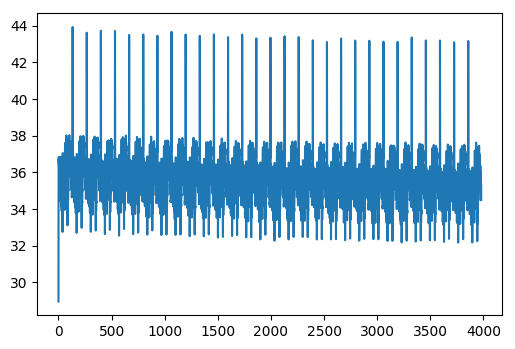

In [110]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
% matplotlib inline
plt.figure()
plt.plot(all_losses[:-20])

# Tempreture

In [ ]:
torch.load(r'C:\Users\hovea\Documents\GitHub\Sample_RNN\rnn_epoch1').fc.bias

# first apoche trainning

In [15]:
max_length = 5
rnn1=true_training_rnn
torch.save(rnn1, r'C:\Users\hovea\Documents\GitHub\Sample_RNN\rnn_epoch1')
rnn=rnn1
# Sample from a category and starting letter
# def sample(keywords_dict, start_letter='A'):
plt.figure(figsize=(10,5))

for start_letter in ['A', 'B','C', 'D', 'E', 'F']:
    with torch.no_grad():  # no need to track history in sampling
    #         category_tensor = categoryTensor(category)

        _input = inputTensor(start_letter, keywords_dict)
    #         _input.to(device)
        hidden = init_prediction()
        output_name = start_letter

        for i in range(max_length):
            output, hidden = rnn.prediction(_input.to(device), hidden.to(device))
            if i==0:
                plt.plot(range(len(output[0][0])),list(output[0][0]), )
#                 plt.show()
            topv, topi = output[0][0].topk(1)
            topi = topi[0]
            letter = keywords_dict['all_letters'][topi]
            output_name += letter
            _input = inputTensor(letter, keywords_dict)
            _input.to(device)
        print(output_name)
plt.legend(['A', 'B','C', 'D', 'E', 'F'])
#     return output_name
# sample(keywords_dict)

NameError: name 'true_training_rnn' is not defined

# Second training

Parameter containing:
tensor([ 0.0324,  0.1671, -0.1060, -0.1080,  0.0040, -0.2190, -0.1777, -0.5530,
         0.0165, -0.2441, -0.2115,  0.2269, -0.0049,  0.0378, -0.1123,  0.1770,
        -0.0561, -0.0881, -0.0272,  0.1534, -0.1331,  0.0223,  0.0187,  0.0385,
         0.0095, -0.0105, -0.0713, -0.3081,  0.0087,  0.0044,  0.0653,  0.0033,
        -0.0174,  0.0619, -0.1527,  0.1715, -0.2158,  0.0372, -0.1772, -0.0264,
        -0.0610,  0.0162,  0.0124, -0.0426,  0.0256,  0.1010, -0.1618, -0.1572,
         0.0205, -0.0754, -0.0160,  0.1524, -0.1194, -0.1111, -0.0070,  0.1712,
         0.0184,  0.0401, -0.0732, -0.0505, -0.2600, -0.0853,  1.3377],
       requires_grad=True)
A:
A:I
A:I:
A:I:z
A:I:zn
BC
BCa
BCal
BCal-
BCal-i
CY
CYO
CYOS
CYOS:
CYOS:B
DO
DOI
DOI

DOI
S
DOI
Sz
EC
ECF
ECFS
ECFSO
ECFSOh
Fn
Fn'
Fn'h
Fn'hR
Fn'hR



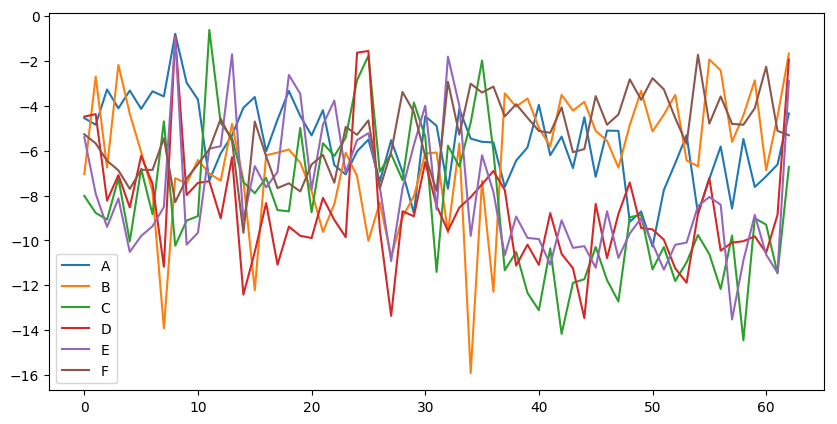

In [59]:
max_length = 5
import numpy as np
# rnn=true_training_rnn
# rnn = torch.load('/Users/apple/PycharmProjects/RNN_CSE254/Sample_RNN/rnn_612_1240',map_location='cpu')
print(rnn.fc.bias)
# Sample from a category and starting letter
# def sample(keywords_dict, start_letter='A'):
plt.figure(figsize=(10,5))

for start_letter in ['A', 'B','C', 'D', 'E', 'F']:
    with torch.no_grad():  # no need to track history in sampling
    #         category_tensor = categoryTensor(category)

        _input = inputTensor(start_letter, keywords_dict)
    #         _input.to(device)
        hidden = init_prediction()
        output_name = start_letter

        for i in range(max_length):
            output, hidden = rnn.prediction(_input, hidden)
            if i==0:
                plt.plot(range(len(output[0][0])),list(output[0][0]), )
#                 plt.show()
#             topv, topi = output[0][0].topk(1)
            topi= sample(output[0][0])
#             topi = topi[0]
            letter = keywords_dict['all_letters'][topi]
            output_name += letter
            _input = inputTensor(letter, keywords_dict)
            _input.to(device)
            print(output_name)
plt.legend(['A', 'B','C', 'D', 'E', 'F'])
#     return output_name
# sample(keywords_dict)

In [1]:
def sample(preds, temperature=1.0):
    # helper function to sample an index from a probability array
    preds = np.asarray(preds).astype('float64')
    preds = preds / temperature
    exp_preds = np.exp(preds)
    preds = exp_preds / np.sum(exp_preds)
    probas = np.random.multinomial(1, preds, 1)
    out = np.random.choice(range(len(chars)), p=probas.ravel())
    return out

In [23]:
output

tensor([[[-4.5295, -4.2618, -4.7250, -4.1999, -3.8873, -4.4217, -3.9116,
          -6.1576, -4.0623, -3.6941, -3.8243, -3.6972, -3.6403, -5.2379,
          -4.9505, -4.9698, -4.1809, -4.2422, -4.1918, -3.1671, -3.8759,
          -3.6004, -4.5704, -4.4868, -4.3364, -4.3853, -3.5229, -6.6972,
          -3.4439, -4.6452, -4.3102, -4.6888, -3.5682, -4.3517, -3.6249,
          -5.3621, -5.9188, -4.5408, -4.6330, -4.5940, -3.8339, -2.7535,
          -4.0968, -3.9654, -5.0667, -4.0870, -4.1447, -4.9680, -4.5317,
          -5.0151, -4.2508, -3.4188, -4.4272, -4.7640, -6.9407, -3.4370,
          -4.0786, -4.2549, -5.1098, -4.3449, -3.7126, -4.5071, -4.6823]]])

In [ ]:
keywords_dict['all_letters'][topi]

In [ ]:
import numpy as np
sum(np.exp(output[0][0]))

In [ ]:
output_name

Parameter containing:
tensor([ 0.1162, -0.0907, -0.0911,  0.0587,  0.0147, -0.2910, -0.2214, -0.3114,
         0.0955, -0.2835, -0.1985,  0.1027,  0.0234,  0.0494, -0.2105, -0.0209,
        -0.0188,  0.0064,  0.0699,  0.0465, -0.1766, -0.1481, -0.1234, -0.0527,
         0.0233, -0.0022, -0.0770, -0.1522, -0.1295, -0.1083, -0.0187, -0.0161,
        -0.2110,  0.0037, -0.3654, -0.0431, -0.1936,  0.2519, -0.0836, -0.1629,
        -0.0299, -0.1023, -0.0472,  0.1141, -0.0863,  0.1140, -0.3717, -0.3138,
        -0.0181, -0.0707, -0.0509,  0.0530, -0.1461, -0.2478,  0.0988,  0.1025,
         0.0548, -0.0312, -0.1480, -0.1282, -0.3812, -0.0769,  2.1515],
       requires_grad=True)
L
tensor([[[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]]])
out tensor([[[ -3.5099

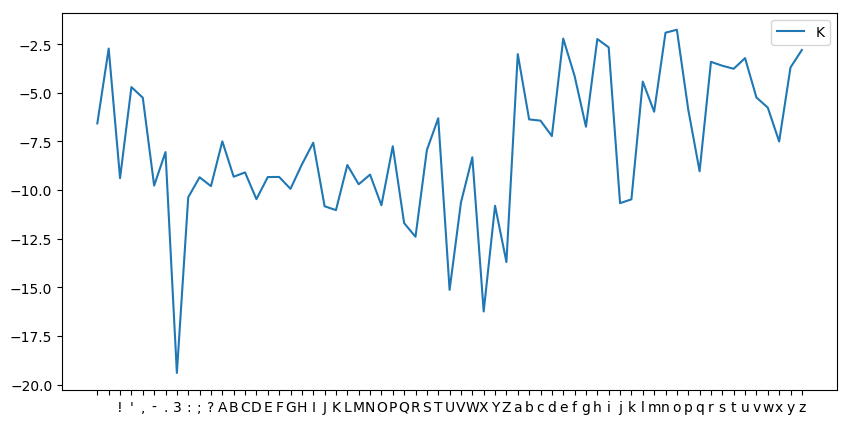

In [113]:
max_length = 100
import numpy as np
rnn=true_training_rnn
# rnn = torch.load('/Users/apple/PycharmProjects/RNN_CSE254/Sample_RNN/rnn_612_1240',map_location='cpu')
print(rnn.fc.bias)
# Sample from a category and starting letter
# def sample(keywords_dict, start_letter='A'):
plt.figure(figsize=(10,5))
# _hidden_test = init_prediction()
_hidden = _hidden_test
# for start_letter in ['A', 'B','C', 'D', 'E', 'F']:
with torch.no_grad():  # no need to track history in sampling
    #         category_tensor = categoryTensor(category)

        _input = inputTensor(start_letter, keywords_dict)
    #         _input.to(device)
#         _hidden = init_prediction()
        output_name = 'LEAR:\n'
        for i in 'LEAR:\n':
            print(i)
            _input = inputTensor(i, keywords_dict)
            print(_input)
            _output, hidden = rnn.prediction(_input, hidden)
            print("out",_output)
        plt.plot(list(keywords_dict['all_letters']),list(_output[0][0]), )
            
        topi= sample(_output[0][0])
        letter = keywords_dict['all_letters'][topi]
        print("The start:", letter)
        output_name += letter
        _input = inputTensor(letter, keywords_dict)
        
        for i in range(max_length):
            output, hidden = rnn.prediction(_input, hidden)
#             if i==0:
                
#                 plt.show()
#             topv, topi = output[0][0].topk(1)
            topi= sample(output[0][0])
#             topi = topi[0]
            letter = keywords_dict['all_letters'][topi]
            output_name += letter
            _input = inputTensor(letter, keywords_dict)
            _input.to(device)
        print(output_name)
plt.legend(["K","I","N","G"," ","L","E","A","R",":","\n"]) 
# plt.xlim()
    

In [61]:
data[:100]

'First Citizen:\nBefore we proceed any further, hear me speak.\n\nAll:\nSpeak, speak.\n\nFirst Citizen:\nYou'

In [75]:
list('aaa')

['a', 'a', 'a']